# Tools and Libraries

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from math import log2

RANDOM_SEED = 42
np.random.seed(42)

# Random Forest (Bagging) Classification Implementation

## 1. Decision Tree Implementation
- The `Node` class represents a single node in a decision tree structure. It is used to store information about a decision point (for internal nodes) or a predicted value (for leaf nodes).
- The `DecisionTreeClassifier` class implements a basic decision tree classifier. It recursively splits the feature space based on information gain, building a binary tree structure to classify data points.

In [140]:
class Node:
  def __init__(self, left=None, right=None, info_gain=None, feature_index=None, threshold=None, value=None):
    self.left = left
    self.right = right
    self.info_gain = info_gain  # Information gain of split
    self.feature_index = feature_index  # Index of feature to split on
    self.threshold = threshold  # Threshold value to split on
    self.value = value  # Predicted value if node is leaf

class DecisionTreeClassifier:
    def __init__(self, max_depth=7, min_samples_split=10):
        """Initialize the decision tree with hyperparameters."""
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum samples required to split a node
        self.root = None  # Root node of the tree, starts as None

    def fit(self, X, y, original_indices = None):
        """Train the decision tree using the input features X and target y."""
        if original_indices is None:
            original_indices = [i for i in range(X.shape[1])]
        # If the current indices are not changed (no feature selection) , the original indcies are [0 ... m] where m is the number of features
        self.root = self.build_tree(X, y, original_indices)  # Build the tree and set the root

    def predict(self, X):
        """Make predictions for each sample in X."""
        if self.root is None:
            raise ValueError("Model has not been trained. Please call 'fit' method first.")
        # Return predictions by traversing the tree for each sample
        return [self.make_prediction(x, self.root) for x in X]

    def make_prediction(self, X, node):
        """Recursively traverse the tree to make a prediction for a single sample."""
        if node.value is not None:  # Leaf node reached
            return node.value
        # Decide which subtree to follow based on the feature value
        if X[node.feature_index] <= node.threshold:
            return self.make_prediction(X, node.left)
        else:
            return self.make_prediction(X, node.right)

    def build_tree(self, X, y, original_indices, depth=0):
        """Recursively build the decision tree."""
        m, n = X.shape  # Number of samples (m) and features (n)
        is_pure = len(np.unique(y)) == 1  # Check if all labels are the same

        # Base case: stop if max depth reached, data is pure, or too few samples
        if depth >= self.max_depth or is_pure or m < self.min_samples_split:
            majority_class = self.compute_output(y)  # Assign majority class to leaf
            return Node(value=majority_class)

        # Find the best split and recursively build left and right subtrees
        best_split = self.get_best_split(X, y)
        if best_split['info_gain'] == float('-inf') :
            # If no information gain, no feature that can split this node further
            return Node(value=self.compute_output(y))
        else:
            left_indices = best_split['left']
            right_indices = best_split['right']
            left_subtree = self.build_tree(X[left_indices, :], y[left_indices], original_indices, depth + 1)
            right_subtree = self.build_tree(X[right_indices, :], y[right_indices], original_indices, depth + 1)

        # Return a node with the split details and subtrees
        return Node(left=left_subtree,
                    right=right_subtree,
                    info_gain=best_split['info_gain'],
                    feature_index=original_indices[best_split['feature_index']],
                    threshold=best_split['threshold'])

    def get_best_split(self, X, y):
        """Find the best feature and threshold to split the data."""
        _, n = X.shape
        best_split = {
            'info_gain': float('-inf'),
            'threshold': None,
            'feature_index': None,
            'left': None,
            'right': None
        }

        # Iterate over all features and their unique values as potential thresholds
        for feature_index in range(n):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                # Split data based on the threshold
                left_indices = X[:, feature_index] <= threshold
                right_indices = X[:, feature_index] > threshold
                left_y = y[left_indices]
                right_y = y[right_indices]
                
                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                
                # Calculate information gain for this split
                split_info_gain = self.compute_information_gain(y, left_y, right_y)

                # Update best split if this one is better
                if split_info_gain > best_split['info_gain']:
                    best_split['info_gain'] = split_info_gain
                    best_split['feature_index'] = feature_index
                    best_split['threshold'] = threshold
                    best_split['left'] = left_indices
                    best_split['right'] = right_indices

        return best_split

    def compute_output(self, y):
        """Compute the majority class for a leaf node."""
        unique_classes, frequency = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(frequency)]  # Most frequent class
        return int(majority_class)

    def compute_entropy(self, y):
        """Calculate the entropy of a set of labels."""
        unique_classes, frequencies = np.unique(y, return_counts=True)
        n_classes = len(y)
        entropy = 0
        for frequency in frequencies:
            probability = frequency / n_classes
            entropy -= probability * log2(probability) if probability > 0 else 0
        return entropy

    def compute_information_gain(self, y, left_y, right_y):
        """Calculate information gain from a split."""
        m = len(y)
        left_m = len(left_y)
        right_m = len(right_y)

        # Entropy before and after the split
        parent_entropy = self.compute_entropy(y)
        left_entropy = self.compute_entropy(left_y) if left_m > 0 else 0
        right_entropy = self.compute_entropy(right_y) if right_m > 0 else 0

        # Weighted average of child entropies
        weighted_entropy = (left_m / m) * left_entropy + (right_m / m) * right_entropy
        information_gain = parent_entropy - weighted_entropy
        return information_gain

## 2. Random Forest Implementation

In [143]:
class RandomForestClassifier:
    def __init__(self, trees = 100):
        """Constructor of the random forest takes number of bootsrapping iterations (m)"""
        self.forest = []  # The forest that will contain m decision trees 
        self.trees = trees
        
    def generate_bootstrapped_dataset(self, X, y, d_features):
        """Sampling a dataset from the original one that has n examples with replacement"""
        n_samples, m_features = X.shape # Getting the number of training examples and features
        samples_indices = np.random.choice (a=n_samples, size=n_samples, replace=True) # Generating random samples indices with replacement
        features_indices = np.random.choice (a=m_features, size=d_features, replace=False) # Generating random features indices
        # Subsetting the original dataset to get only the bootstrapped examples and the d chosen features        
        X_bootstrap = X[samples_indices, : ]
        X_bootstrap = X_bootstrap[ : , features_indices]
        y_bootstrap = y[samples_indices]
        return X_bootstrap, y_bootstrap, features_indices

    def fit(self, X, y, d_features = None):
        """Construct the forest with number 'trees' number of trees"""
        if d_features is None:
            d_features = int (np.sqrt(X.shape[1]))
        for i in range (self.trees):
            X_bootstrap, y_bootstrap, original_features_indcies = self.generate_bootstrapped_dataset(X, y, d_features)
            # max_depth = min(7, X_bootstrap.shape[1])
            self.forest.append(DecisionTreeClassifier(max_depth = X_bootstrap.shape[1]))
            self.forest[-1].fit(X_bootstrap, y_bootstrap, original_features_indcies)
        """For each tree to be in the forest:
                - sample a new dataset (bootstrapped one) with only a subset of the featres
                - Train the ith descition tree then add it to the forest
        """

    def predict(self, X):
        """Classify new samples using the random forest we created"""
        classifications = [] # Initialize a matrix for predictions, classifications[i, : ] is the vector of predictions for sample i with every tree in the forest
        # Build the predictions matrix with size (trees * n_examples)
        for tree in self.forest:
            classifications.append(tree.predict(X))
        
        # Turn it into a numpy matrix for easier calculations
        predictions_matrix = np.array(classifications)
        # Accuring the array that has the most frequent (majority vote application) value to be the class if the example
        final_prediction, _ = mode(predictions_matrix, axis=0)
        return final_prediction
    

## 3. Loading and Preprocessing the Dataset

In [146]:
# Load the dataset
heart_df = pd.read_csv('heart.csv')
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [148]:
# Encode categorical features using One-Hot Encoding
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(heart_df[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
modified_df = pd.concat([heart_df.drop(categorical_features, axis=1), encoded_df], axis=1)

modified_df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,54,150,195,0,122,0.0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [150]:
# Split the dataset into training, validation, and test sets
X = modified_df.drop('HeartDisease', axis=1)
y = modified_df['HeartDisease']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=RANDOM_SEED, stratify=y_temp)

# Convert to NumPy arrays
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(642, 15)
(92, 15)
(184, 15)


## 4. Training the Random Forest Classifier

In [153]:
# At the beggining, we start with d_features = sqrt(total features) and forest size = 100 
random_forest_classifier = RandomForestClassifier(trees = 100)
random_forest_classifier.fit(X_train, y_train)
# The Accuracy rate for the training data
y_pred = random_forest_classifier.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)*100
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 87.07


## 5. Hyperparameter Tuning
We will tune the hyperparameters `trees` and `d_features` using the validation set.

In [155]:
def plot_confusion_matrix(cm):
    """Plot the confusion matrix."""
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar(label='Count')
    plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
    plt.yticks([0, 1], ['True 0', 'True 1'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [160]:
# Tune hyperparameters
features = X_train.shape[1]
sqrt = int(np.sqrt(features))
d_features_values = [sqrt, sqrt+2, int(0.5*features), int(0.75*features), features] 
trees_values = [10, 20, 50, 100, 150, 250, 500]

misclassification_rates = np.zeros((len(d_features_values), len(trees_values)))

for i, d_features in enumerate(d_features_values):
    for j, trees in enumerate(trees_values):
        random_forest_classifier = RandomForestClassifier(trees=trees)
        random_forest_classifier.fit(X_train, y_train, d_features)
        y_pred = random_forest_classifier.predict(X_val)
        misclassification_rates[i, j] = np.mean(y_pred != y_val)
        print(f"Misclassification Rate (FeaturesNumber={d_features} and Trees={trees}): {misclassification_rates[i, j]}")
    print("")

Misclassification Rate (FeaturesNumber=3 and Trees=10): 0.22826086956521738
Misclassification Rate (FeaturesNumber=3 and Trees=20): 0.1956521739130435
Misclassification Rate (FeaturesNumber=3 and Trees=50): 0.17391304347826086
Misclassification Rate (FeaturesNumber=3 and Trees=100): 0.21739130434782608
Misclassification Rate (FeaturesNumber=3 and Trees=150): 0.18478260869565216
Misclassification Rate (FeaturesNumber=3 and Trees=250): 0.18478260869565216
Misclassification Rate (FeaturesNumber=3 and Trees=500): 0.18478260869565216

Misclassification Rate (FeaturesNumber=3 and Trees=10): 0.1956521739130435
Misclassification Rate (FeaturesNumber=3 and Trees=20): 0.20652173913043478
Misclassification Rate (FeaturesNumber=3 and Trees=50): 0.21739130434782608
Misclassification Rate (FeaturesNumber=3 and Trees=100): 0.1956521739130435
Misclassification Rate (FeaturesNumber=3 and Trees=150): 0.18478260869565216
Misclassification Rate (FeaturesNumber=3 and Trees=250): 0.17391304347826086
Misclas

Best Features Number: 5
Best Forest Size: 20
Misclassification Rate: 0.120
Accuracy: 0.880
F1-Score: 0.891


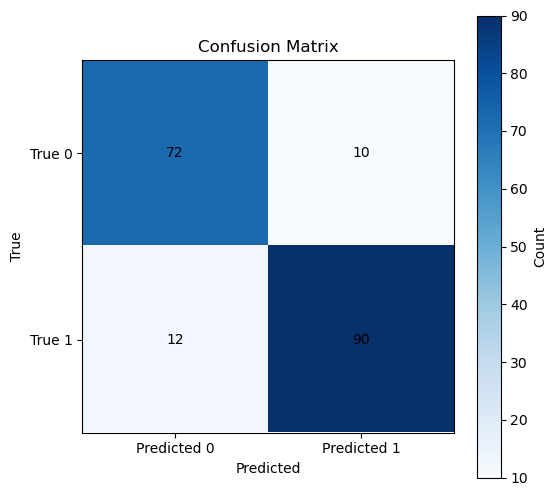

In [166]:
# Find the best hyperparameters
best_idx = np.unravel_index(np.argmin(misclassification_rates, axis=None), misclassification_rates.shape)
best_features_number = d_features_values[best_idx[0]]
best_trees = trees_values[best_idx[1]]
print(f"Best Features Number: {best_features_number}")
print(f"Best Forest Size: {best_trees}")

# Intialize and train the Random Forest Classifier with the best hyperparameters
random_forest_classifier = RandomForestClassifier(trees = best_trees)
random_forest_classifier.fit(X_train, y_train, best_features_number)
# Make predictions and evaluate the model on the test set
y_pred = random_forest_classifier.predict(X_test)

# Calculate the misclassification rate, accuracy, F1-score, and confusion matrix
misclassification_rate = np.mean(y_pred != y_test)
print(f"Misclassification Rate: {misclassification_rate:.3f}")

acc_score = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc_score:.3f}")

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

------

# Logistic Regression (Using Scikit-Learn)

## 1. Scaling the Features (affects logistic regression severely)

In [171]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 2. Train the Cross Validation-Included Logistic Regression Model

In [174]:
# Try both regularizers l1 and l2
logistic_regression_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=200, tol=1e-5)
logistic_regression_l2 = LogisticRegressionCV(penalty='l2', max_iter=200, tol=1e-5)

# Train both of them
logistic_regression_l1.fit(X_train_scaled, y_train)
logistic_regression_l2.fit(X_train_scaled, y_train)

LogisticRegressionCV(max_iter=200, tol=1e-05)

## 3. Test the l1 and l2 regularized Logistic Regressions

Logistic Regression with l1 regularization Scores:
Accuracy Score = 89.67
F1 Score = 90.91


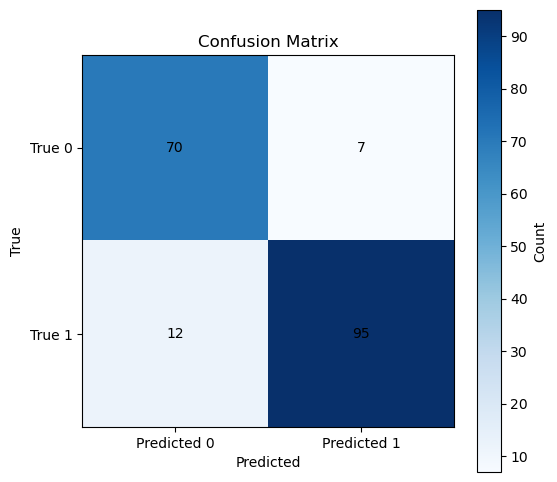


Logistic Regression with l2 regularization Scores:
Accuracy Score = 88.59
F1 Score = 89.86


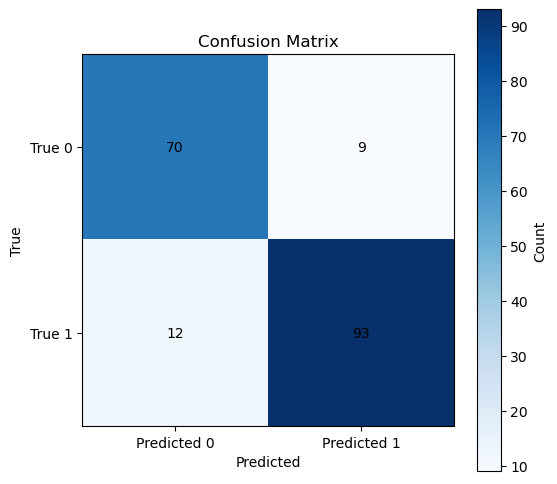

In [177]:
def calculate_scores(y_pred, y):
    acc = accuracy_score(y_pred, y)*100
    f1 = f1_score(y_pred, y)*100
    cm = confusion_matrix(y_pred, y)
    print(f'Accuracy Score = {acc:.2f}')
    print(f'F1 Score = {f1:.2f}')
    plot_confusion_matrix(cm)
    
# Predict the test sets
y1_pred = logistic_regression_l1.predict(X_test_scaled)
y2_pred = logistic_regression_l2.predict(X_test_scaled)

print(f'Logistic Regression with l1 regularization Scores:')
calculate_scores(y1_pred, y_test)
print()
print(f'Logistic Regression with l2 regularization Scores:')
calculate_scores(y2_pred, y_test)    

## 4. Train the Logistic Regression Model

In [180]:
# Try both l1 and l2 as regularizers
logistic_regression_l1 = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', max_iter=200, tol=1e-4)
logistic_regression_l2 = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=200, tol=1e-4)

# Train the models with default Value of C (1.0)
logistic_regression_l1.fit(X_train_scaled, y_train)
logistic_regression_l2.fit(X_train_scaled, y_train)

print(f'Training Accuracy with l1 and C = 1 is {logistic_regression_l1.score(X_train_scaled, y_train)*100 : .2f}')
print(f'Training Accuracy with l2 and C = 1 is {logistic_regression_l2.score(X_train_scaled, y_train)*100 : .2f}')

Training Accuracy with l1 and C = 1 is  86.60
Training Accuracy with l2 and C = 1 is  86.60


In [182]:
# Try and continue with both l1 and l2 combined as our regularizer
logistic_regression = LogisticRegression(C=1.0, penalty='elasticnet', solver='saga', max_iter=200, tol=1e-4, l1_ratio=0.5)

# Train the models with default Value of C (1.0)
logistic_regression.fit(X_train_scaled, y_train)

print(f'Training Accuracy with C = 1 and equal participation for l1 and l2 is {logistic_regression.score(X_train_scaled, y_train)*100 : .2f}')

Training Accuracy with C = 1 and equal participation for l1 and l2 is  86.60


## 5. Tuning the Hyperparameters (l1_ratio, l2_ratio, C) using Validation Set

Misclassification Rate with C = 0.001 and l1 ratio = 0 is 0.17391304347826086
Misclassification Rate with C = 0.001 and l1 ratio = 0.01 is 0.17391304347826086
Misclassification Rate with C = 0.001 and l1 ratio = 0.05 is 0.17391304347826086
Misclassification Rate with C = 0.001 and l1 ratio = 0.1 is 0.22826086956521738
Misclassification Rate with C = 0.001 and l1 ratio = 0.3 is 0.44565217391304346
Misclassification Rate with C = 0.001 and l1 ratio = 0.4 is 0.44565217391304346
Misclassification Rate with C = 0.001 and l1 ratio = 0.5 is 0.44565217391304346
Misclassification Rate with C = 0.001 and l1 ratio = 0.7 is 0.44565217391304346
Misclassification Rate with C = 0.001 and l1 ratio = 0.9 is 0.44565217391304346
Misclassification Rate with C = 0.001 and l1 ratio = 1 is 0.44565217391304346

Misclassification Rate with C = 0.01 and l1 ratio = 0 is 0.1956521739130435
Misclassification Rate with C = 0.01 and l1 ratio = 0.01 is 0.1956521739130435
Misclassification Rate with C = 0.01 and l1 ra

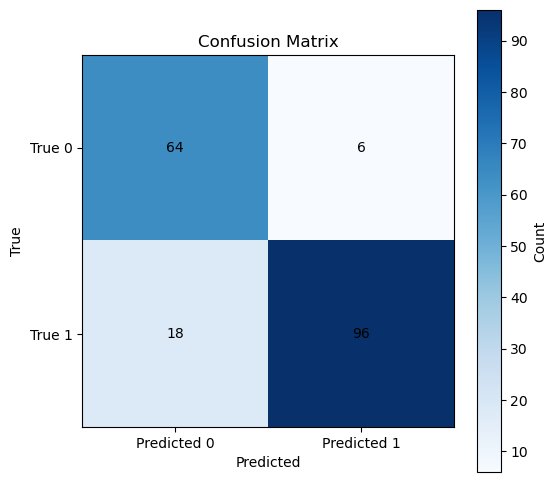

In [185]:
# Different l1_ratio values implies l2_ration = 1 - l1_ratio
c_values = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.7, 0.8, 0.9, 1, 5, 10, 100, 1000]
l1_ratio_values = [0, 0.01, 0.05, 0.1, 0.3, 0.4, 0.5, 0.7, 0.9, 1]
misclassification_rates = np.zeros((len(c_values), len(l1_ratio_values)))

for i, c in enumerate(c_values):
    for j, l1 in enumerate(l1_ratio_values):
        lg =  LogisticRegression(C=c, penalty='elasticnet', solver='saga', max_iter=200, tol=1e-5, l1_ratio=l1)
        lg.fit(X_train_scaled, y_train)
        y_pred = lg.predict(X_val_scaled)
        misclassification_rates[i, j] = np.mean(y_pred != y_val)
        print(f'Misclassification Rate with C = {c} and l1 ratio = {l1} is {misclassification_rates[i,j]}')
    print()

# Extracting Optimal C and l1 ratio from the tuning procces
print()
best_c_index, best_l1_index = np.unravel_index(np.argmin(misclassification_rates, axis=None), misclassification_rates.shape)
best_c = c_values[best_c_index]
best_l1 = l1_ratio_values[best_l1_index]
print(f'Optimal C = {best_c} and Optimal l1 ratio = {best_l1}')

# Train the model with the Optimal Parameters and Test it 
optimal_params_model = LogisticRegression(C=best_c, penalty='elasticnet', solver='saga', max_iter=200, tol=1e-5, l1_ratio=best_l1)
optimal_params_model.fit(X_train_scaled, y_train)
y_pred = optimal_params_model.predict(X_test_scaled)
calculate_scores(y_pred, y_test)